### Copyright 2020 Yuke Xie
#### Potsdam dataset:
####     image size: 6000x6000
####     labels: ['biulding', 'car', 'background']
####     croped image size: 128x128x5

In [122]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import scipy.io as sc
import cv2

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [123]:
# import training crop images
mat_train = sc.loadmat('objects_potsdam_2_10_crops.mat')
train_images = np.moveaxis(mat_train['crops'], 3, 0)
train_labels = mat_train['labels']
print('size of the training images',train_images.shape)
print('size of the training labels',train_labels.shape)

# import test crop images
mat_test = sc.loadmat('objects_potsdam_2_11_crops.mat')
test_images = np.moveaxis(mat_test['crops'], 3, 0)
test_labels = mat_test['labels']
print('size of the test images',test_images.shape)
print('size of the test labels',test_labels.shape)

size of the training images (390, 128, 128, 5)
size of the training labels (390, 1)
size of the test images (328, 128, 128, 5)
size of the test labels (328, 1)


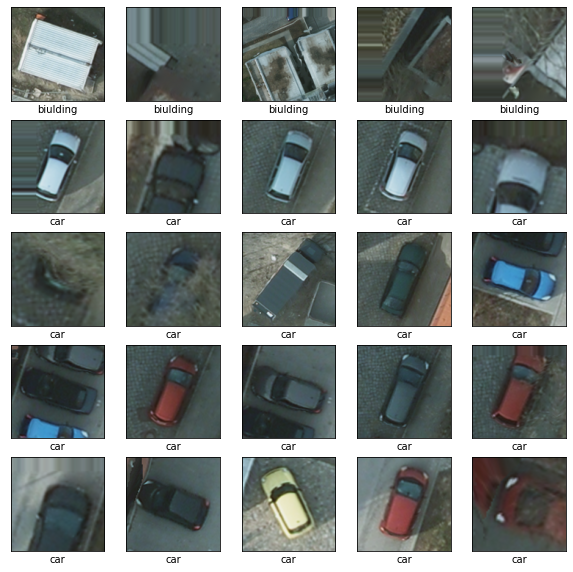

In [124]:
# Examinate and plot the first 25 crop image of the training dataset
# define the class labels
class_names = ['biulding', 'car', 'background']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i+80,:,:,0:3], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i+80][0]])
plt.show()

### 构造卷积神经网络模型

In [125]:
# Create the convolutional base using a stack of Conv2D and MaxPooling2D layers
model = models.Sequential()
model.add(layers.Conv2D(32, 3, activation='relu', input_shape=(128, 128, 5))) # Our image shape is [128*128*5]
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, 3, activation='relu'))
# Add the dense layer(full connected layer)
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(3))
# Check the summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 32)      1472      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

In [126]:
# Compile and train the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
13/13 [==============================] - 4s 98ms/step - loss: 1.1417 - accuracy: 0.3900 - val_loss: 0.7936 - val_accuracy: 0.8506
Epoch 2/10
13/13 [==============================] - 0s 34ms/step - loss: 0.8982 - accuracy: 0.6073 - val_loss: 0.5234 - val_accuracy: 0.8963
Epoch 3/10
13/13 [==============================] - 1s 94ms/step - loss: 0.5537 - accuracy: 0.8022 - val_loss: 0.6346 - val_accuracy: 0.7134
Epoch 4/10
13/13 [==============================] - 0s 29ms/step - loss: 0.3695 - accuracy: 0.8536 - val_loss: 0.4087 - val_accuracy: 0.9024
Epoch 5/10
13/13 [==============================] - 0s 33ms/step - loss: 0.3830 - accuracy: 0.8336 - val_loss: 0.4379 - val_accuracy: 0.8750
Epoch 6/10
13/13 [==============================] - 0s 28ms/step - loss: 0.2734 - accuracy: 0.9047 - val_loss: 0.2754 - val_accuracy: 0.9116
Epoch 7/10
13/13 [==============================] - 0s 32ms/step - loss: 0.2475 - accuracy: 0.9027 - val_loss: 0.4420 - val_accuracy: 0.8384
Epoch 8/10
13

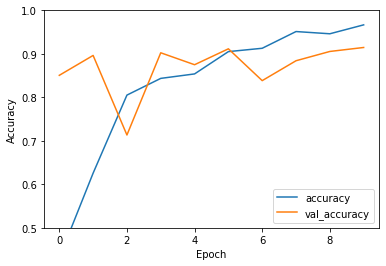

11/11 - 0s - loss: 0.3856 - accuracy: 0.9146
0.9146341681480408


In [127]:
# Evaluate the model
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()
# Visualize loss
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
# Print the test accuracy
print(test_acc)

In [128]:
# Predict a new data
img = test_images[0,:,:,:]
print(img.shape)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f}% confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

(128, 128, 5)
This image most likely belongs to car with a 99.52% confidence.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


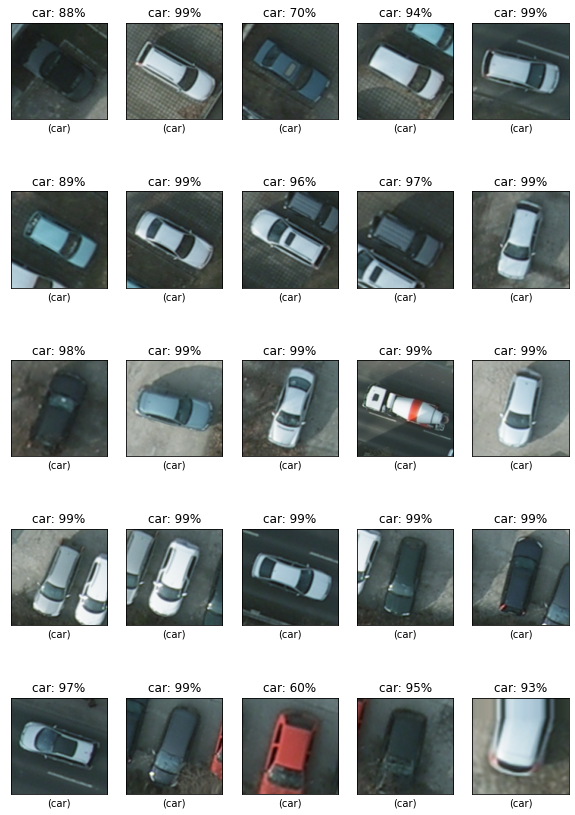

In [129]:
# Predict the first 25 test data

plt.figure(figsize=(10,15))
for i in range(25):
    ax=plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i+50,:,:,0:3], cmap=plt.cm.binary)
    
    img = test_images[i+50,:,:,:]
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    #print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score)))
    ax.title.set_text(class_names[np.argmax(score)]+': '+str(int(100 * np.max(score)))+'%')
    plt.xlabel('('+class_names[test_labels[i+50][0]]+')')
plt.show()

(6000, 6000, 3)


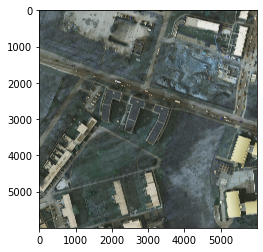

In [130]:
# Plot the test tile image
tile_test = cv2.imread('top_potsdam_2_11_RGB.tif')
print(tile_test.shape)
plt.imshow(tile_test)

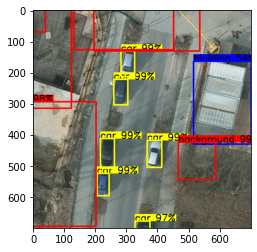

In [131]:
# Visualize all the prediction on the test tile image

# read the boundary file
bb_test_mat = sc.loadmat('objects_potsdam_2_11_boundingBoxes.mat')
bbs = np.asarray(bb_test_mat['object_classes'])
bbs_0 = np.array(bbs[0][0][0][0][4]) # biulding
bbs_1 = np.array(bbs[0][1][0][0][4]) # car
bbs_2 = np.array(bbs[0][2][0][0][4]) # background
# stack all the boundary information to fit the images
bbs = np.vstack((bbs_0,bbs_1,bbs_2))
# creat a dictionary to store the color of the label
color_dict = {'biulding': (255, 0, 0), 'car': (0, 255, 255), 'background':(0, 0, 255)}
for j in range(len(bbs)): # All images
    # Predict all the images from label[i]
    img = test_images[j,:,:,:]
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    # predicted label & percentage
    predicted_label = class_names[np.argmax(score)]
    predicted_percent = str(int(100 * np.max(score)))
    predicted_text = predicted_label+' '+predicted_percent+'%'
    
    # Calculate textsize & putText with background
    font_type, font_scale, font_color, font_thickness=cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,0),2
    text_size, _ = cv2.getTextSize(predicted_text, font_type, font_scale, font_thickness)
    text_w, text_h = text_size
    cv2.rectangle(tile_test, (bbs[j][0],bbs[j][1]), (bbs[j][0] + text_w, bbs[j][1] - text_h), color_dict[predicted_label], -1)
    cv2.putText(tile_test, predicted_text,(bbs[j][0],bbs[j][1] + font_scale -1),
              font_type, font_scale, font_color, font_thickness)
    # Draw boundary
    ptLeftTop = (bbs[j][0],bbs[j][1])
    ptRightBottom = (bbs[j][0]+bbs[j][2],bbs[j][1]+bbs[j][3])
    point_color = color_dict[predicted_label] # BGR
    thickness = 3
    lineType = 4
    cv2.rectangle(tile_test, ptLeftTop, ptRightBottom, point_color, thickness, lineType)

# Save image with text
cv2.imwrite('with_text.tif', tile_test)
plt.imshow(tile_test[1600:2300,5300:6000,[2,1,0]])